# Project Milestone 01 (NE 591) - Serial neutron diffusion code
- **Author**: Kirill Shumilov
- **Date**: Thu, Feb 14, 2025

# 0. Analysis Code Setup

In [1]:
import json
import pathlib
import subprocess

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from dataclasses import dataclass, asdict, field

def gaussian_2d(x, y, x0=0.5, y0=0.5, fwhm=1.0):
    sigma = fwhm / (2 * np.sqrt(2 * np.log(2)))
    return np.exp(-((x - x0) ** 2 + (y - y0) ** 2) / (2 * sigma ** 2)) / (2 * np.pi * sigma ** 2)


def lorentzian_2d(x, y,  x0=0.5, y0=0.5, fwhm=1.0):
    return fwhm / (2 * np.pi) / ((x - x0) ** 2 + (y - y0) ** 2 + (fwhm / 2) ** 2) ** 1.5


@dataclass
class Grid:
    a: float = 1
    b: float = 1
    M: int = 10
    N: int = 10

    def get_mesh(self) -> tuple[np.ndarray, np.ndarray]:
        x = np.linspace(0, self.a, self.M + 2)[1:-1]
        y = np.linspace(0, self.b, self.N + 2)[1:-1]
        return np.meshgrid(x, y)

    @classmethod
    def build_square(cls, l: float = 1.0, n: int = 10) -> 'Grid':
        return cls(l, l, n, n)

    @property
    def shape(self) -> tuple[int, int]:
        return (self.M, self.N)

    @property
    def size(self) -> int:
        return np.prod(self.shape)

    @classmethod
    def from_json(cls, filename) -> 'Grid':
        with open(filename, 'r') as f:
            j = json.load(f)

        return cls.from_dict(j)

    @classmethod
    def from_dict(cls, j):
        return cls(
            j['space']['X'],
            j['space']['Y'],
            j['points']['NX'],
            j['points']['NY'],
        )

    def to_dict(self):
        return {
            'space': {'X': self.a, 'Y': self.b},
            'points': {'NX': self.M, 'NY': self.N},
        }

    def to_json(self, filename: str):
        with open(filename, 'w') as f:
            json.dump(self.to_dict(), f)


@dataclass
class Problem:
    grid: Grid = field(default_factory=Grid)
    D: float = 1
    S: float = 1
    source: np.ndarray | None = None

    def __post_init__(self):
        if self.source is None:
            self.source = np.zeros(self.grid.shape)

        if self.source.shape != self.grid.shape:
            raise ValueError(f'grid and source shape must match: {self.grid.shape} != {self.source.shape}')

    @classmethod
    def from_point_sources(cls, grid,
                           locs: tuple[float, float] | list[tuple[float, float]],
                           fwhms: float | list[float] = 1e-2,
                           qs: float | list[float] = 1.0,
                           kernel=gaussian_2d, **kwargs) -> 'Problem':
        x, y = grid.get_mesh()
        source = np.zeros_like(x)

        locs = locs if not isinstance(locs, tuple) else [locs]
        fwhms = fwhms if not isinstance(fwhms, float) else [fwhms] * len(locs)
        qs = qs if not isinstance(qs, float) else [qs] * len(locs)

        for (x0, y0), fwhm, q in zip(locs, fwhms, qs):
            source += q * kernel(x, y, x0=x0, y0=y0, fwhm=fwhm)

        return cls(grid, source=source, **kwargs)

    @classmethod
    def from_line_source(cls, grid, a = 0.0, b=0.5, q=1.0, distance=1e-2, **kwargs) -> 'Problem':
        x, y = grid.get_mesh()
        source = np.zeros_like(x)
        d = np.abs(y - a * x - b) / np.sqrt(a ** 2 + 1)
        source[d < distance] = q
        return cls(grid, source=source, **kwargs)

    @classmethod
    def from_json(cls, filename) -> 'Problem':
        with open(filename, 'r') as f:
            j = json.load(f)

        return cls.from_dict(j)

    @classmethod
    def from_dict(cls, j):
        return cls(
            Grid.from_dict(j['grid']),
            j['absorption_scattering'],
            j['diffusion_coefficient'],
            np.asarray(j['source']['m_data']).reshape(j['source']['m_rows'], j['source']['m_cols'])
        )

    def to_dict(self):
        d = {
            'grid': grid.to_dict(),
            'absorption_scattering': self.D,
            'diffusion_coefficient': self.S,
            'source': {
                'm_rows': self.source.shape[0],
                'm_cols': self.source.shape[1],
                'm_data': self.source.flatten().tolist()
            }
        }

        return d

    def to_json(self, filename: str):
        with open(filename, 'w') as f:
            json.dump(self.to_dict(), f)


@dataclass
class Parameters:
    algorithm: str
    tolerance: float | None = None
    max_iters: int | None = None
    relaxation_factor: float | None = None

    @classmethod
    def from_dict(cls, j):
        return cls(
            j['algorithm'],
            j.get('iter_settings', {}).get('tolerance', None),
            j.get('iter_settings', {}).get('max_iter', None),
            j.get('relaxation_factor', None)
        )

    def to_dict(self):
        d = {
            'algorithm': self.algorithm,
        }

        if self.algorithm != 'lup':
            d['iter_settings'] = {
                'tolerance': self.tolerance,
                'max_iter': self.max_iters,
            }

            if self.algorithm == 'sor':
                d['relaxation_factor'] = self.relaxation_factor

        return d

    def to_json(self, filename: str):
        with open(filename, 'w') as f:
            json.dump(self.to_dict(), f)


@dataclass
class Input:
    params: Parameters
    problem: Problem

    def to_dict(self):
        return {
            'params': self.params.to_dict(),
            'problem': self.problem.to_dict(),
        }

    def to_json(self, filename: str):
        with open(filename, 'w') as f:
            json.dump(self.to_dict(), f)


@dataclass
class Solution:
    prob: Problem
    params: Parameters
    flux: np.ndarray
    residual_error: float
    time: int
    memory: int | None = None

    converged: bool | None = None
    relative_error: float | None = None
    iterations: int | None = None

    @classmethod
    def from_dict(cls, data) -> 'Solution':
        return cls(
            Problem.from_dict(data['project']['problem']),
            Parameters.from_dict(data['project']['params']),
            np.asarray(data['flux']['m_data']).reshape(data['flux']['m_rows'], data['flux']['m_cols']),
            data['residual_error'],
            data['time'],

            converged=data.get('converged'),
            relative_error=data.get('relative_error'),
            iterations=data.get('iterations'),
        )

    @classmethod
    def from_json(cls, filename) -> 'Solution':
        with open(filename, 'r') as f:
            j = json.load(f)

        return cls.from_dict(j)

In [3]:
analysis_dir = pathlib.Path('.').absolute()
examples_dir = analysis_dir.parent / 'examples'
executable = analysis_dir.parent / 'shumilov_project02'


def parse_peak_memory(time_output: str) -> int:
    return int(time_output.strip().split('\n')[-1].strip().split()[0])


def run_solution(input_path: pathlib.Path) -> Solution:
    result = subprocess.run(['time', '-lha', executable, input_path, '--input-json', '--output-json'], capture_output=True, text=True)
    solution = Solution.from_dict(json.loads(result.stdout))
    solution.memory = parse_peak_memory(result.stderr)
    return solution

In [4]:
lup_params = Parameters(algorithm='lup')
sor_params = Parameters(algorithm='sor', tolerance=1e-07, max_iters=12_000, relaxation_factor=1.905)
gs_params = Parameters(algorithm='gs', tolerance=1e-07, max_iters=12_000)
pj_params = Parameters(algorithm='pj', tolerance=1e-07, max_iters=12_000)

param_sets = [lup_params, sor_params, gs_params, pj_params]

# 1. Description of Work
In this project milestone, we have implemented the steady state, one speed diffusion equation solver. The assumptions on the medium include a non-multiplying, isotropic scattering homogeneous medium, in a two-dimensional rectangular region, under vaccum boundary conditions on all four sides. To achieve this goal the following steps have been taken. The equations are solved using LUP, Point-Jacobi, Gauss-Seidel, and/or Succesive-over-Relaxation methods.

Steps Taken:
------------
1) Read & validate the input from the file.

Make sure that the following invariants are true throughout the exectuation of the code.
- Positive $a$ & $b$
- $N\ \&\ M > 0$
- $D > 0$ and $\Sigma_a > 0$
- Source is assume to be non-negative

For iterative methods, positive tolerance, maximum number of iterations, and relaxation factor (SOR only are read).

2) Construct the operator. To find the solution to the steady-state of the system we use the edge-centered finite-difference method to discretize the diffusion operator. Thus a matrix form of the operator, $A(D, \Sigma_a)$, and RHS vector, $b(q)$, must be found. The linear set of equations
\begin{equation}
-D\left[\frac{\phi_{i+1,j}-2\phi_{i,j}+2\phi_{i+1,j}}{\delta^2} + \frac{\phi_{i,j-1}-2\phi_{i,j}+2\phi_{i,j + 1}}{\gamma^2}\right] + \Sigma_a\phi_{i,j} = q_{ij}
\end{equation}
are cast such that diagonal elements of the matrix are equal to $2D(\frac{1}{\delta^2} + \frac{1}{\gamma^2}) + \Sigma_a$ and off diagonal elements are $-D\frac{1}{\delta^2}$ or $-D\frac{1}{\gamma^2}$, dending on the positive of the cell w.r.t. to the edge of the box.

3) For LUP algorithm, a full matrix, $A$, is built. It is then factorized using LUP algorithm. The, the resulting system of equations $LUx=Pb$ is then solved using forward and backward substitution.

4) For PJ, GS, and SOR algorithms, a full matrix is not used. Instead, a Sparse-Matrix vector routine is implemented that allows us to avoid storing and iterating over the zero elements of the matrix. Each respective algorithm kenerl is applied iteratively to the guess of $x$ until absolute relative error ends up being below tolerance (or maximum number of iterations is acheived).

# 2. Numerical Experiments

To check correctness of the calculation a number experiments have been conducted. The examples of input files, output files, and aggregated data is stored under `analysis/tests/` directory.

## Grid Size

We start by varying grid size of the system with a gaussian source in top left corner of square surface.

By varying grid size of the system we checked that as $N,M$-number of grid-points increased the solution coverged to a "blur-like" solution. Not only the this experiment allows to check whehter the solution is improves with grid size, but also allows to profile and test execution time scaling, memory usage, error, number of iterations (for iterative methods). We expect to see a LUP algorithm to increase fasted in time and memory as it requires construction of the full matrix. PJ, GS, and SOR algorithms will have a larger residual error, but better time and memory scaling.

## Symmetry

The next set of experiments is aimed at testing adherence of the solution to symmetries embedded into the system

The first experiment tests whether the source placed in different corners of the square area results in the same solution.
The second experiment tests whether exchanging $a$ and $b$ for $a\neq b$ results in the same solution.

In both cases, we expect the same solution.

# 3. Results

## Grid Size

In [5]:
grid_size = [8, 16, 32, 59, 64, 70]

tests_dir = analysis_dir / 'tests'
input_filename = 'p{}_{}.json'
result_filename = 'p{}_{}_result.json'

solutions = {}
data = []

for n in grid_size:
    grid = Grid.build_square(n=n)
    problem = Problem.from_point_sources(grid, (0.25, 0.25), fwhms=0.05, kernel=gaussian_2d)

    for params in param_sets:
        inp = Input(params, problem)

        input_path = tests_dir / input_filename.format(n, params.algorithm)
        result_path = tests_dir / result_filename.format(n, params.algorithm)
        inp.to_json(input_path)

        result = subprocess.run(['time', '-lha', executable, input_path, '--input-json', '-o', result_path, '--output-json'], 
                                capture_output=True, text=True)

        solution = Solution.from_json(result_path)
        solution.memory = parse_peak_memory(result.stderr)

        solutions[(n, params.algorithm)] = solution

        data.append({
            'n': n,
            'algo': params.algorithm,
            'residual': solution.residual_error,
            'time': solution.time,
            'memory': solution.memory,
            'converged': bool(solution.converged),
            'iterations': solution.iterations,
            'relative': solution.relative_error,
            'relative_lup': np.abs(solutions[(n, 'lup')].flux - solution.flux).max()
        })

df = pd.DataFrame.from_records(data)

In [6]:
df.to_csv(tests_dir / 'data.csv')

In [7]:
df['sec'] = df['time'] / 1e3
df['kbytes'] = df['memory'] / 1024

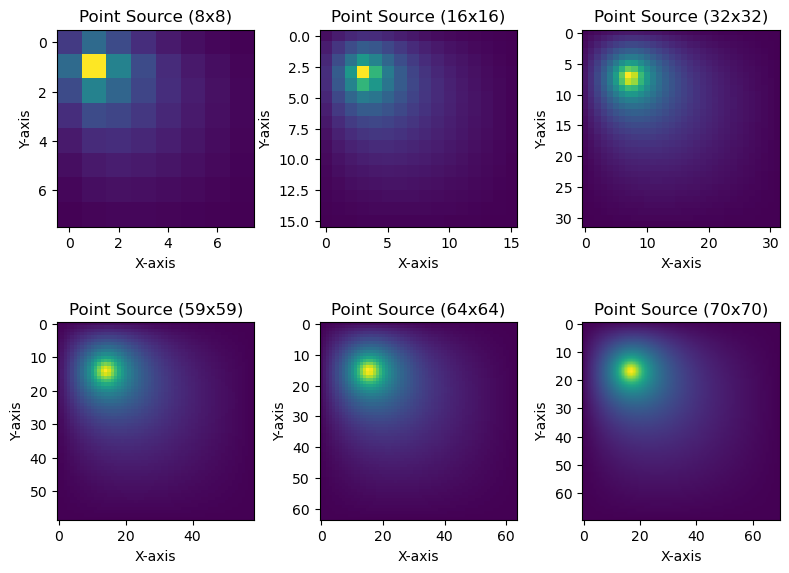

In [8]:
fig, axes = plt.subplots(2, 3, layout='tight', figsize=(8, 6))

for k, n in enumerate(grid_size):
    sol = solutions[(n, 'lup')]

    i, j = divmod(k, 3)
    ax = axes[i, j]
    img = ax.imshow(sol.flux, cmap='viridis')  # Use 'viridis' colormap

    # Add labels and title (optional)
    ax.set_xlabel("X-axis")
    ax.set_ylabel("Y-axis")
    ax.set_title(f"Point Source ({n}x{n})")

plt.show()

From the graphs above, we can indeed see the "smoothing" of the blob, allowing us to conclude that increasing the grid size improves the solution as expected.

## Scaling Analysis

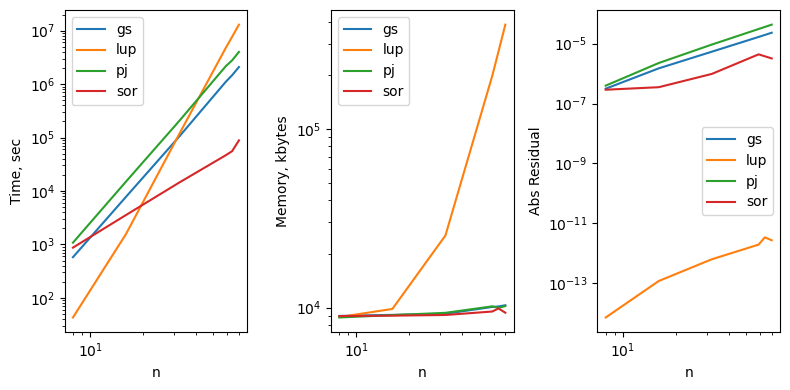

In [9]:
fig, axes = plt.subplots(1, 3, layout='tight', figsize=(8, 4))

for algo, dfa in df.groupby('algo'):
    axes[0].loglog('n', 'sec', data=dfa, label=algo)
    axes[1].loglog('n', 'kbytes', data=dfa, label=algo)
    axes[2].loglog('n', 'residual', data=dfa, label=algo)

for ax in axes:
    ax.legend()
    ax.set_xlabel('n')

axes[0].set_ylabel('Time, sec')
axes[1].set_ylabel('Memory, kbytes')
axes[2].set_ylabel('Abs Residual')

plt.show()

From the graph above we see, as expected, that LUP solution "blows up" both in time and memory (especially memory), as it requires building of the full matrix. After a certain point, LUP becomes impractical in both time and memory and "is beaten" by iterative algorithms.

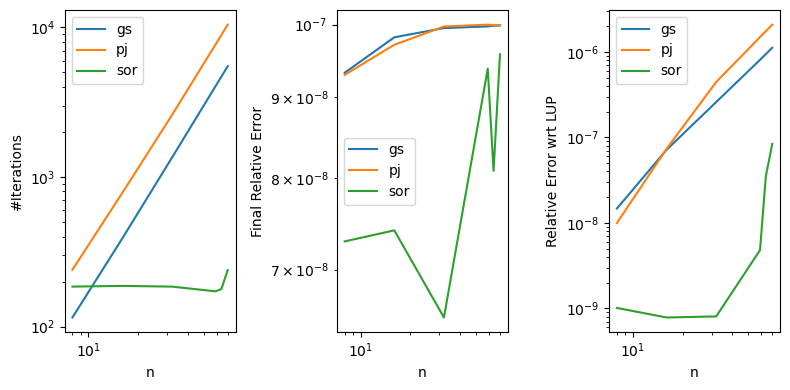

In [10]:
fig, axes = plt.subplots(1, 3, layout='tight', figsize=(8, 4))

for algo, dfa in df[df.algo != 'lup'].groupby('algo'):
    axes[0].loglog('n', 'iterations', data=dfa, label=algo)
    axes[1].loglog('n', 'relative', data=dfa, label=algo)
    axes[2].loglog('n', 'relative_lup', data=dfa, label=algo)

for ax in axes:
    ax.legend()
    ax.set_xlabel('n')

axes[0].set_ylabel('#Iterations')
axes[1].set_ylabel('Final Relative Error')
axes[2].set_ylabel('Relative Error wrt LUP')

plt.show()

Looking at the errors and number of iterations used for PJ, GS, and SOR we see expected behaviour. Number of iterations, Relative error (wrt to previous iterate), and relative error grows for PS and GS significantly in comparison to SOR. SOR is heavily dependent on relaxation factor (1.905 used here). However, even with suboptimal relaxation factor it outperforms all other algorithms. Notice, that Relative error ends up being smaller smaller than relative error wrt to LUP, especially for PJ and GS. This is expected, as the convergence is slow for those to algorithms and change in guess vector becomes smaller much faster than the approach to the actual solution.

## Grid Shape

### Rotational

In [11]:
grid = Grid.build_square(n=64)
topleft = Problem.from_point_sources(grid, (0.25, 0.25), fwhms=0.05, kernel=gaussian_2d)

inp = Input(sor_params, topleft)
input_path = tests_dir / 'top_left.json'
result_path = tests_dir / 'top_left_result.json'
inp.to_json(input_path)
result = subprocess.run(['time', '-lha', executable, input_path, '--input-json', '-o', result_path, '--output-json'], 
                        capture_output=True, text=True)
topleft_result = Solution.from_json(result_path)

In [12]:
bottomleft = Problem.from_point_sources(grid, (0.25, 0.74), fwhms=0.05, kernel=gaussian_2d)
inp = Input(sor_params, bottomleft)
input_path = tests_dir / 'bottom_left.json' 
result_path = tests_dir / 'bottom_left_result.json' 
inp.to_json(input_path)
result = subprocess.run(['time', '-lha', executable, input_path, '--input-json', '-o', result_path, '--output-json'], 
                        capture_output=True, text=True)
bottomleft_result = Solution.from_json(result_path)

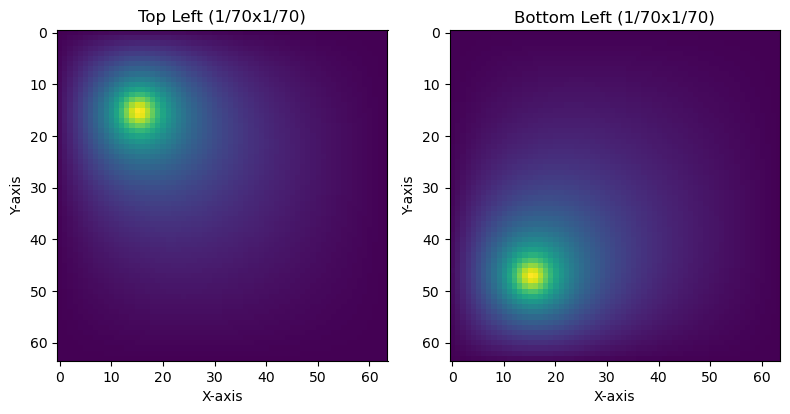

In [13]:
fig, axes = plt.subplots(1, 2, layout='tight', figsize=(8, 6))

sol = solutions[(n, 'lup')]

ax = axes[0]
img = ax.imshow(topleft_result.flux, cmap='viridis')  # Use 'viridis' colormap

# Add labels and title (optional)
ax.set_xlabel("X-axis")
ax.set_ylabel("Y-axis")
ax.set_title(f"Top Left (1/{n}x1/{n})")

ax = axes[1]
img = ax.imshow(bottomleft_result.flux, cmap='viridis')  # Use 'viridis' colormap

# Add labels and title (optional)
ax.set_xlabel("X-axis")
ax.set_ylabel("Y-axis")
ax.set_title(f"Bottom Left (1/{n}x1/{n})")

plt.show()

### Symmetry in Grid Shape

In [14]:
grid = Grid(1, 5, M=64, N=64)
tall = Problem.from_point_sources(grid, (0.25, 1), fwhms=0.05, kernel=gaussian_2d)

inp = Input(sor_params, tall)
input_path = tests_dir / 'tall.json'
result_path = tests_dir / 'tall_result.json'
inp.to_json(input_path)
result = subprocess.run(['time', '-lha', executable, input_path, '--input-json', '-o', result_path, '--output-json'], 
                        capture_output=True, text=True)
tall_result = Solution.from_json(result_path)

In [15]:
grid = Grid(5, 1, M=64, N=64)
long = Problem.from_point_sources(grid, (1, 0.25), fwhms=0.05, kernel=gaussian_2d)

inp = Input(sor_params, long)
input_path = tests_dir / 'long.json'
result_path = tests_dir / 'long_result.json'
inp.to_json(input_path)
result = subprocess.run(['time', '-lha', executable, input_path, '--input-json', '-o', result_path, '--output-json'], 
                        capture_output=True, text=True)
long_result = Solution.from_json(result_path)

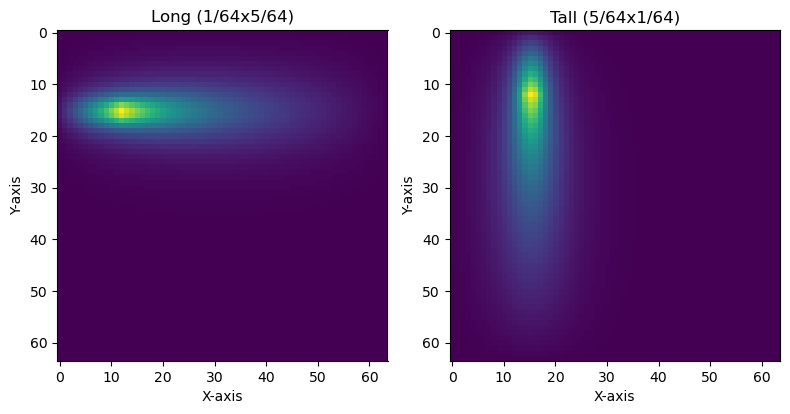

In [16]:
fig, axes = plt.subplots(1, 2, layout='tight', figsize=(8, 6))

sol = solutions[(n, 'lup')]

ax = axes[0]
img = ax.imshow(long_result.flux, cmap='viridis')  # Use 'viridis' colormap

# Add labels and title (optional)
ax.set_xlabel("X-axis")
ax.set_ylabel("Y-axis")
ax.set_title(f"Long ({1}/64x{5}/64)")

ax = axes[1]
img = ax.imshow(tall_result.flux, cmap='viridis')  # Use 'viridis' colormap

# Add labels and title (optional)
ax.set_xlabel("X-axis")
ax.set_ylabel("Y-axis")
ax.set_title(f"Tall ({5}/64x{1}/64)")

plt.show()

From the graphs above, we can see that the system adheres to the symmetries. For Tall/Long graphs, pay attention not the square shape of the plot (the individual cells are plotted), but to the grid sizes

# 4. Discussion

As can be seen from the results, the solves direct and iterative implemnted for the the given diffusion problem work and provides a physically correct soltuion. Both geomtries of tested provide expected solutions, respecting the symmetry of the initial source.

The execution time of the code grows polynomially. For small systems, it is nearly flat, as the small matrices fit nicely into caches of the system. However, the larger the grid size, the larger is memory requriement, the more frequent are the "cache-misses" and the execution time grows signficiantly. 
For iterative algorithms, this is not as big of an issues, as the matrix elements are computed on the fly and do not require fetching them from memory. Direct method (LUP) sufferes from that drastically. 

# 5. Conclusion

In this work, we implemented the steady state, one speed diffusion equation in a non-multiplying, isotropic scattering homogeneous medium, in a two-dimensional rectangular region, under vaccum boundary conditions on all four sides and its solver using LUP factoriztion direct method, Point-Jacobi, Gauss-Seidel and Successive over relaxation iterative methods. The code is functional and provides physically correct solutions for given systems. 

The scaling testing clearly shows that for anything significantly large direct methods becomes impractical and iterative methods take spotlight.